# CVAEs

http://ijdykeman.github.io/ml/2016/12/21/cvae.html
<img src="http://ijdykeman.github.io/assets/cvae_figures/cvae_diagram.svg" width=600>

## test

* CVAE 에서 encoder 에 condition 을 꼭 박아야 하나?
    * 안 그래도 인코더는 이미지를 레이텐트 벡터로 잘 변환할거고, 그러면 디코더에만 컨디션을 주면 우리가 원하는 것을 얻을 수 있을 것이다
* 그것도 되는거 같기는 한데 인코더에 컨디션을 박아줘야 더 잘 됨. 어찌보면 당연한 얘기다. 추가적인 정보 c 를 주니까.
* http://wiseodd.github.io/techblog/2016/12/17/conditional-vae/ 참조 (별 얘긴 없음)

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('../MNIST_data/', one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [4]:
def show_plot(samples):
    fig = plot(samples)
    plt.show()
    plt.close(fig)

In [5]:
x_dim = 784
h_dim = 128
z_dim = 100

In [6]:
# q(z|x)
# input: x
# output: mu, sigma for z
def encoder(x):
    net = x
    with tf.variable_scope("encoder"):
        net = tf.layers.dense(net, h_dim, activation=tf.nn.relu, 
                              weights_initializer=tf.contrib.layers.xavier_initializer())
        net = tf.layers.dense(net, h_dim, activation=tf.nn.relu, 
                              weights_initializer=tf.contrib.layers.xavier_initializer())
        mu = tf.layers.dense(net, z_dim)
        log_var = tf.layers.dense(net, z_dim)
    
    return mu, log_var

In [7]:
# p(x|z)
# input: z
# output: logits of x
def decoder(z, reuse=False):
    net = z
    with tf.variable_scope("decoder", reuse=reuse):
        net = tf.layers.dense(net, h_dim, activation=tf.nn.relu, 
                              weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=reuse)
        net = tf.layers.dense(net, h_dim, activation=tf.nn.relu, 
                              weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=reuse)
        logits = tf.layers.dense(net, x_dim, reuse=reuse)
        x = tf.nn.sigmoid(logits)
    
    return x, logits

In [8]:
def sample_z(mu, log_var):
    # tf.shape works declarative (works in graph). mu.shape works imperative.
    eps = tf.random_normal(shape=tf.shape(mu), mean=0.0, stddev=1.0) # N(0,1)
    sigma = tf.exp(log_var / 2) # log(sigma^2) = 2log(sigma)
    return mu + sigma*eps

In [9]:
def one_hot(dense, ndim=10):
    N = dense.shape[0]
    ret = np.zeros([N, ndim])
    ret[np.arange(N), dense] = 1
    return ret

In [10]:
# make tf graph
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])

# xy = tf.concat((X,y), axis=1)
z_mu, z_log_var = encoder(X)
z = sample_z(z_mu, z_log_var)
zy = tf.concat((z,y), axis=1)
x_generated, y_logits = decoder(zy)

# reconstruction loss for Bernoulli MLP as decoder (appendix C.1 in paper)
# sigmoid_cross_entropy: z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_logits, labels=X))
# regularization loss (kl-divergence, appendix B in paper)
reg_loss = -0.5 * tf.reduce_sum(1 + z_log_var - z_mu**2 - tf.exp(z_log_var))
loss = recon_loss + reg_loss # minimize
# ELBO = -loss # recon_loss 랑 reg_loss 에 loss 라는 이름이 붙어서 위처럼 해주는게 맞는것같음.

train_op = tf.train.AdamOptimizer().minimize(loss)

summary_op = tf.summary.merge([
        tf.summary.scalar("loss", loss),
        tf.summary.scalar('reconstruction_loss', recon_loss),
        tf.summary.scalar('regularization_loss', reg_loss)
    ])

In [11]:
# sampling graph
z_sampling = tf.placeholder(tf.float32, shape=[None, z_dim])
zy_sampling = tf.concat((z_sampling, y), axis=1)
x_sampling, _ = decoder(zy_sampling, reuse=True)

[1/100] loss: 25384.84


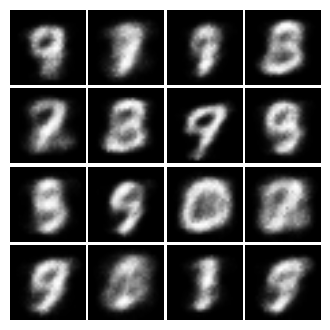

[10/100] loss: 14134.20


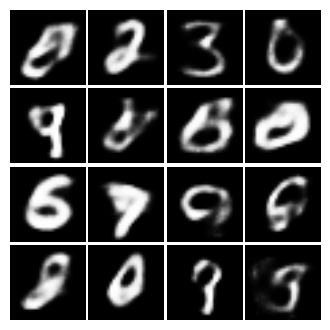

[20/100] loss: 13478.19


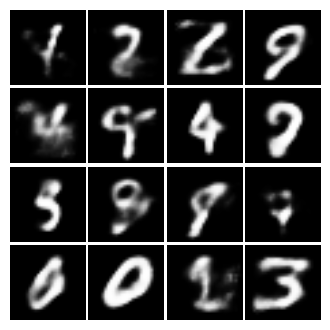

[30/100] loss: 13223.72


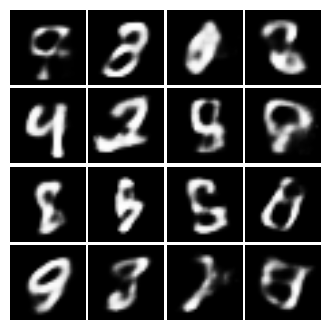

[40/100] loss: 13076.17


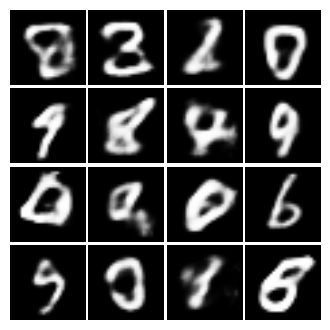

[50/100] loss: 12976.49


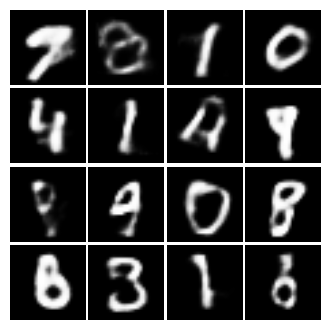

[60/100] loss: 12902.44


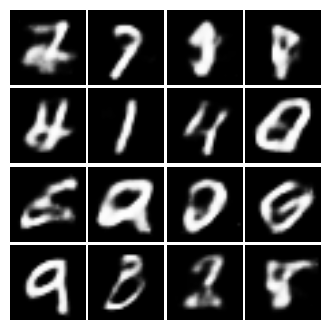

[70/100] loss: 12838.13


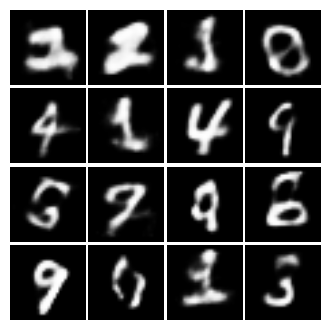

[80/100] loss: 12792.05


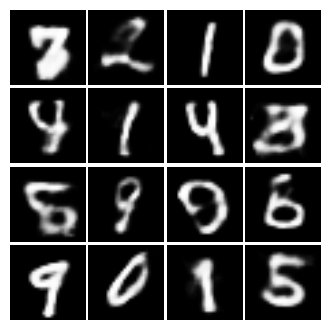

[90/100] loss: 12747.70


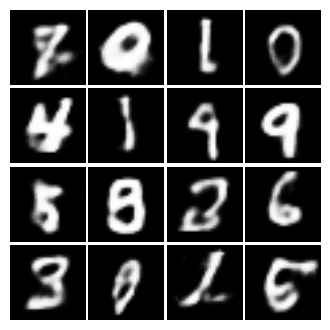

[100/100] loss: 12720.34


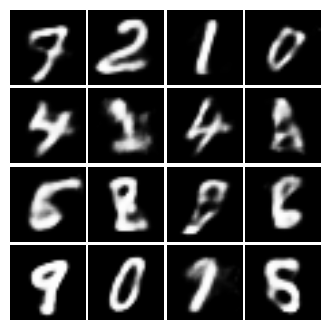

In [12]:
epoch_n = 100
batch_size = 128
N = mnist.train.num_examples

sess = tf.Session()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter("./tmp/", sess.graph)
global_step = 0

for epoch in range(epoch_n):
    loss_avg = 0
    for _ in range(N // batch_size):
        global_step += 1
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        _, loss_cur, summary_cur = sess.run([train_op, loss, summary_op], {X: X_batch, y: y_batch})
        loss_avg += loss_cur
        writer.add_summary(summary_cur, global_step)
    
    if epoch == 0 or (epoch+1) % 10 == 0:
        loss_avg /= (N // batch_size)
        print("[{}/{}] loss: {:.2f}".format(epoch+1, epoch_n, loss_avg))
        
        samples = sess.run(x_sampling, {z_sampling: np.random.randn(16, z_dim), y: mnist.test.labels[:16]}) 
        show_plot(samples)

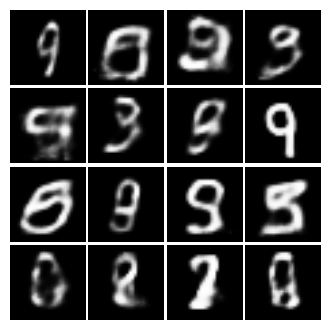

In [13]:
# x_sampling = decoder. 
# z_sampling, 즉 z vector 를 넣어주었을 때 decoder 만 사용해서 decode 함
samples = sess.run(x_sampling, {z_sampling: np.random.randn(16, z_dim), y: one_hot(np.array([9]*16))}) 
show_plot(samples)

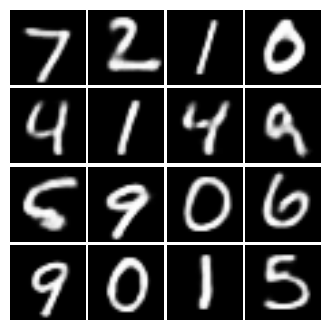

In [14]:
# x_generated = encoder + decoder
samples = sess.run(x_generated, {X: mnist.test.images[:16], y: mnist.test.labels[:16]})
show_plot(samples)

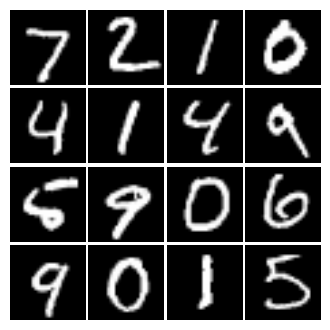

In [15]:
# real images
show_plot(mnist.test.images[:16])

# Latent space walking

In [16]:
def interpolate(st, ed, n=16):
    diff = ed - st
    step = diff / n
    return np.array([st + step*i for i in range(n)])

In [17]:
encoded_z = sess.run(z, {X: mnist.test.images[:16]})

In [18]:
walking_z = interpolate(encoded_z[0], encoded_z[15])
samples = sess.run(x_sampling, {z_sampling: walking_z})
show_plot(samples)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_1' with dtype float
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: decoder_1/Sigmoid/_29 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_21_decoder_1/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'Placeholder_1', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-1295a686a154>", line 4, in <module>
    y = tf.placeholder(tf.float32, shape=[None, 10])
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/array_ops.py", line 1526, in placeholder
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_1' with dtype float
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: decoder_1/Sigmoid/_29 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_21_decoder_1/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
